# Paramagnetic Effects: Pseudo-Contact Shift

In [1]:
import sys
sys.path.append('/Users/albertsmith/Documents/GitHub.nosync')
sys.path.append('/Users/albertsmith/Documents/GitHub')
import pyRelaxSim as RS
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%matplotlib notebook

The shift in the NMR peak due to an isotropic coupling to a polarized electron is known as the contact shift. The pseudo-contact shift, on the other hand, results from the anisotropic part of the coupling to the electron. The anisotropic hyperfine coupling's Hamiltonian has an average of zero when sampling all orientations, however. This means that isotropic tumbling or MAS would in principal remove the hyperfine coupling entirely, even if the electron is polarized. Another factor comes in, however, which is the fact that the $g_{xz}$ and $g_{yz}$ components of the electron g-tensor may be large enough to tilt the electron's quantization axis away from the magnetic field's *z*-axis, such that MAS or isotropic tumbling no longer results in a complete averaging of the hyperfine Hamiltonian.

## Pseudocontact shift for a static spectrum
Without MAS or motion to average the coupling, a pseudocontact shift appears without g-tensor anisotropy, although the average shift is indeed zero

<IPython.core.display.Javascript object>


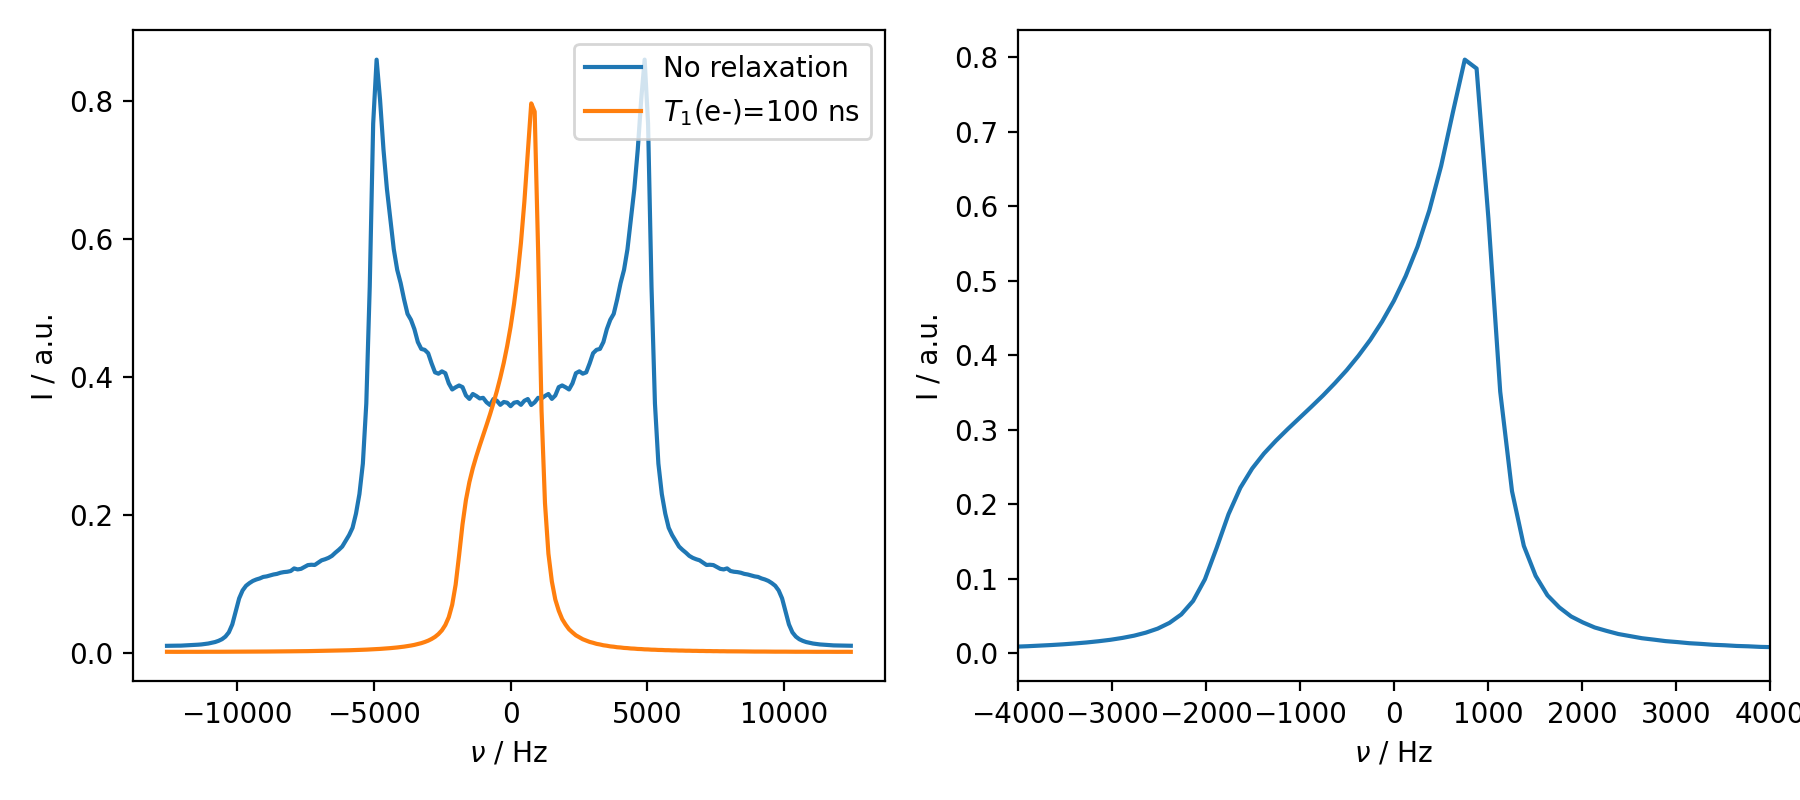

In [5]:
delta=2e4
gxx=gyy=gzz=2
g_euler=[0,2*np.pi/5,0]

ex=RS.ExpSys(v0H=600,vr=0,Nucs=['13C','e-'],T_K=50,LF=True,pwdavg=RS.PowderAvg(q=9))
ex.set_inter('hyperfine',i0=0,i1=1,Axx=-delta/2,Ayy=-delta/2,Azz=delta)
ex.set_inter('g',i=1,gxx=gxx,gyy=gyy,gzz=gzz)

L=RS.Liouvillian(ex)
U=L.U(Dt=.00004)

fig,ax=plt.subplots(1,2)
fig.set_size_inches([9,4])

rho=RS.Rho(rho0='13Cx',detect='13Cp')
rho.DetProp(U,n=100)
rho.downmix()
rho.plot(FT=True,apodize=True,ax=ax[0])

L.add_relax(Type='T1',i=1,T1=1e-7)
L.add_relax(Type='T2',i=1,T2=1e-12)
L.add_relax(Type='recovery')

U=L.U(Dt=.00004)

rho=RS.Rho(rho0='13Cx',detect=f'{ex.Peq[0]*2}*13Cp')
rho.DetProp(U,n=100)
rho.downmix()
rho.plot(FT=True,apodize=True,ax=ax[0])
rho.plot(FT=True,apodize=True,ax=ax[1])

fig.tight_layout()
ax[1].set_xlim([-4000,4000])
ax[0].legend(('No relaxation',r'$T_1$(e-)=100 ns'))

Then, if include magic-angle spinning, the influence of the pseudo-contact shift is removed

<IPython.core.display.Javascript object>


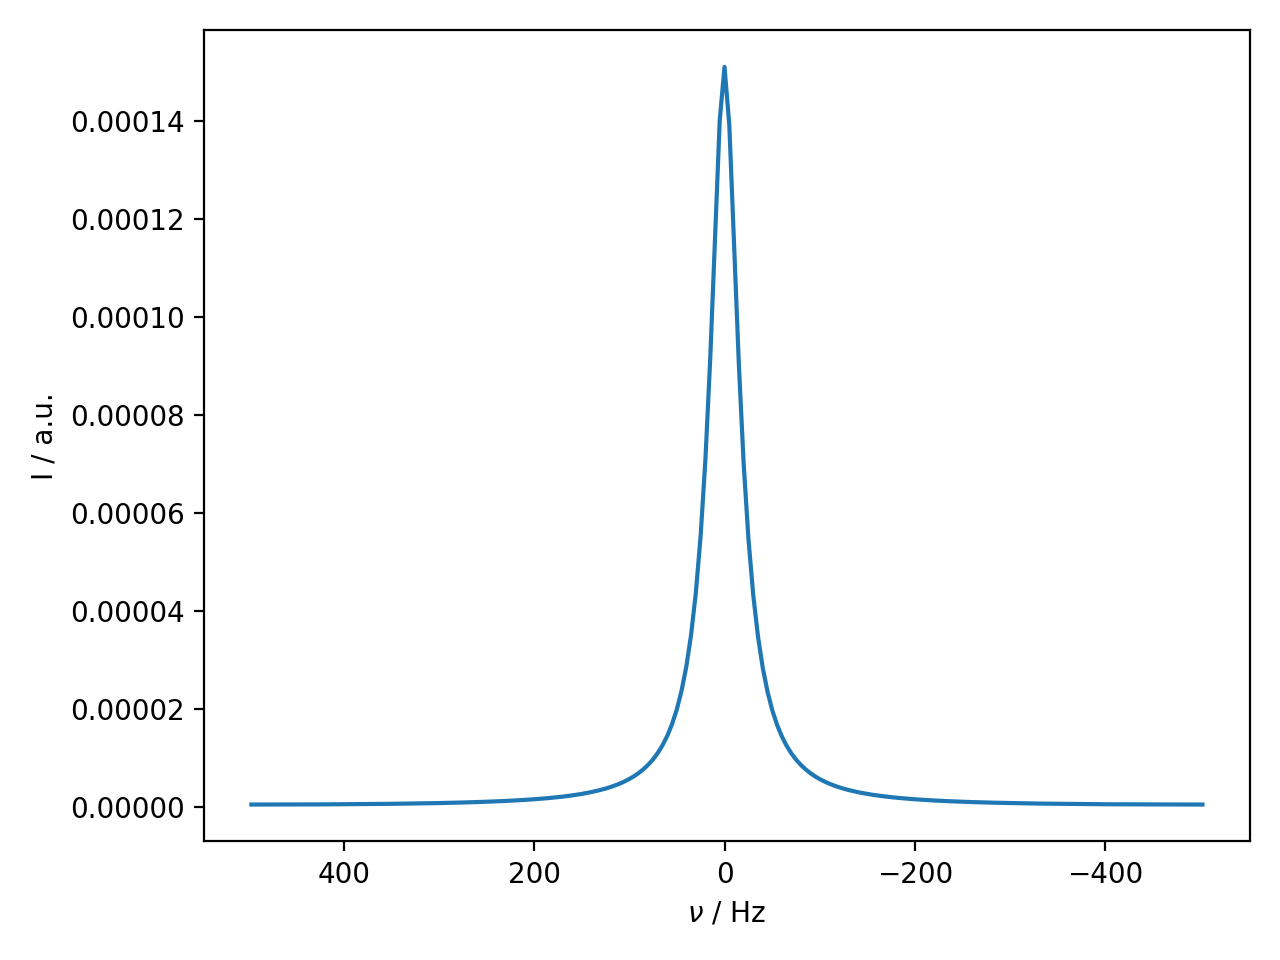

In [3]:
delta=2e4
gxx=gyy=gzz=2
g_euler=[0,2*np.pi/5,0]

ex=RS.ExpSys(v0H=600,vr=10000,Nucs=['13C','e-'],T_K=50,LF=True,pwdavg=RS.PowderAvg(q=5))
ex.set_inter('hyperfine',i0=0,i1=1,Axx=-delta/2,Ayy=-delta/2,Azz=delta)
ex.set_inter('g',i=1,gxx=gxx,gyy=gyy,gzz=gzz)

L=RS.Liouvillian(ex)

L.add_relax(Type='T1',i=1,T1=1e-7)
L.add_relax(Type='T2',i=1,T2=1e-12)
L.add_relax(Type='recovery')

U=L.U()**10

rho=RS.Rho(rho0='13Cx',detect='13Cp')
rho.DetProp(U,n=100)
rho.downmix()
fig=rho.plot(FT=True,apodize=True).figure
fig.tight_layout()

In the next example, we mimic isotropic tumbling with symmetric four-site hopping on a tetrahedral geometry. We include both an anisotropic g-tensor and dipolar hyperfine coupling. We have to include explicit relaxation on the electron to force the system to relax to thermal equilibrium (required for the residual coupling), although the main source of relaxation is the isotropic motion.

<IPython.core.display.Javascript object>


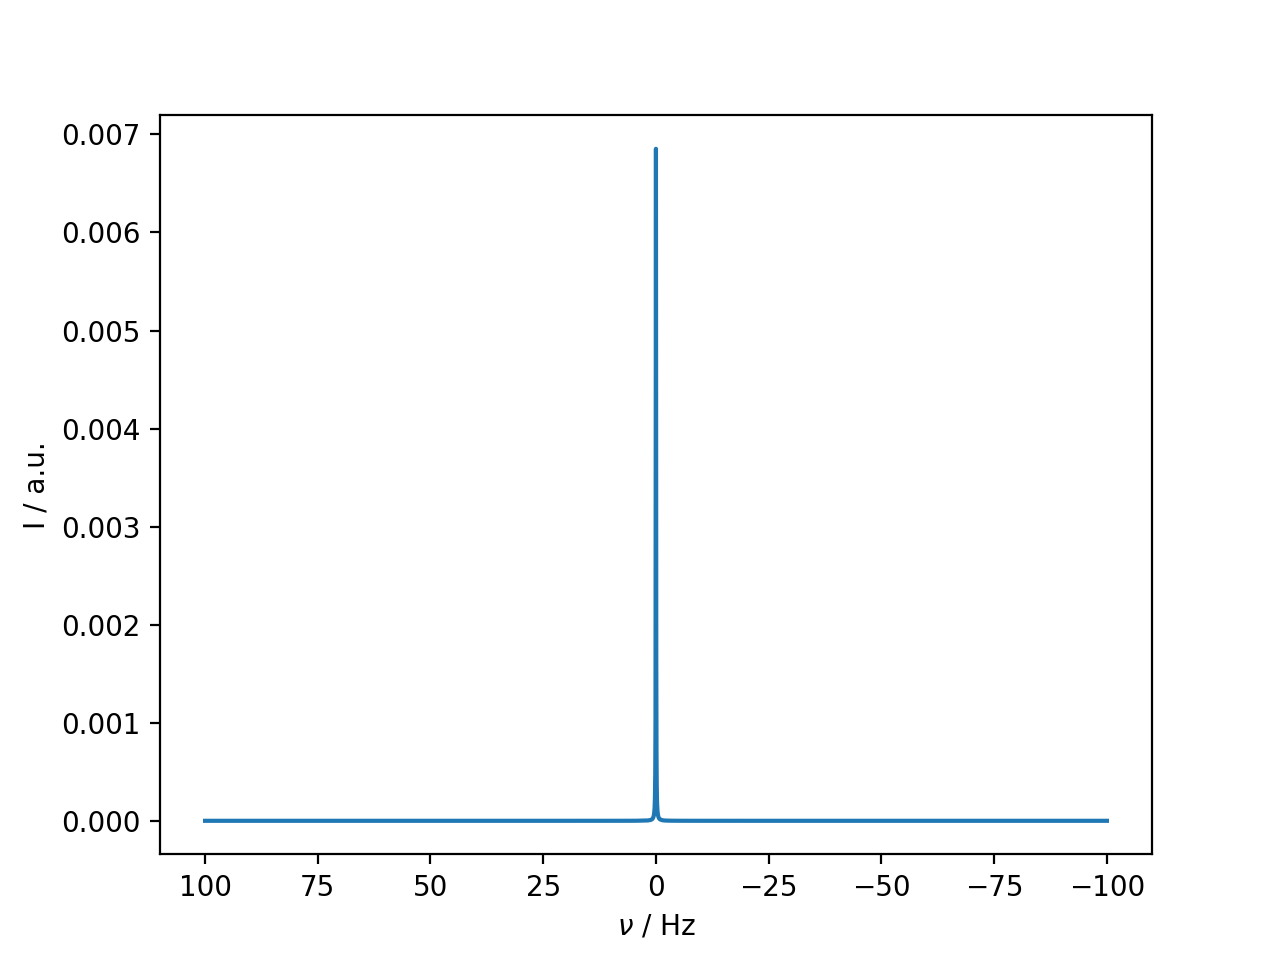

<AxesSubplot:xlabel='$\\nu$ / Hz', ylabel='I / a.u.'>

In [8]:
delta=2e4
g_euler=[0,2*np.pi/5,0]
gxx=gyy=gzz=2

ex=[]   #Since we have four states in exchange, we'll put them in a list
ex.append(RS.ExpSys(v0H=600,vr=0,rotor_angle=0,Nucs=['13C','e-'],T_K=100,LF=True,pwdavg=RS.PowderAvg('alpha0beta0')))     #1-spin system at 600 MHz (14.1 T). LF=True : Lab Frame
ex[-1].set_inter('hyperfine',i0=0,i1=1,Axx=-delta/2,Ayy=-delta/2,Azz=delta)
ex[-1].set_inter('g',i=1,gxx=gxx,gyy=gyy,gzz=gzz,euler=g_euler)

phi_tetra=np.arccos(-1/3)
for k in range(3):
    ex.append(ex[0].copy())
    ex[-1].set_inter('hyperfine',i0=0,i1=1,Axx=-delta/2,Ayy=-delta/2,Azz=delta,euler=[0,phi_tetra,k*2*np.pi/3])
    ex[-1].set_inter('g',i=1,gxx=gxx,gyy=gyy,gzz=gzz,euler=[g_euler,[0,phi_tetra,k*2*np.pi/3]])
    
L=RS.Liouvillian(ex)
L.kex=RS.Tools.fourSite_sym(tc=1e-9)  #Four site symmetric exchange


L.add_relax(Type='T1',i=1,T1=1e-12)
L.add_relax(Type='T2',i=1,T2=1e-12)
L.add_relax(Type='recovery')

U=L.U(Dt=5e-3)

rho=RS.Rho(rho0='13Cx',detect='13Cp')
rho.DetProp(U,n=4000)
rho()
rho.downmix()
rho.plot(FT=True,apodize=True)

<IPython.core.display.Javascript object>


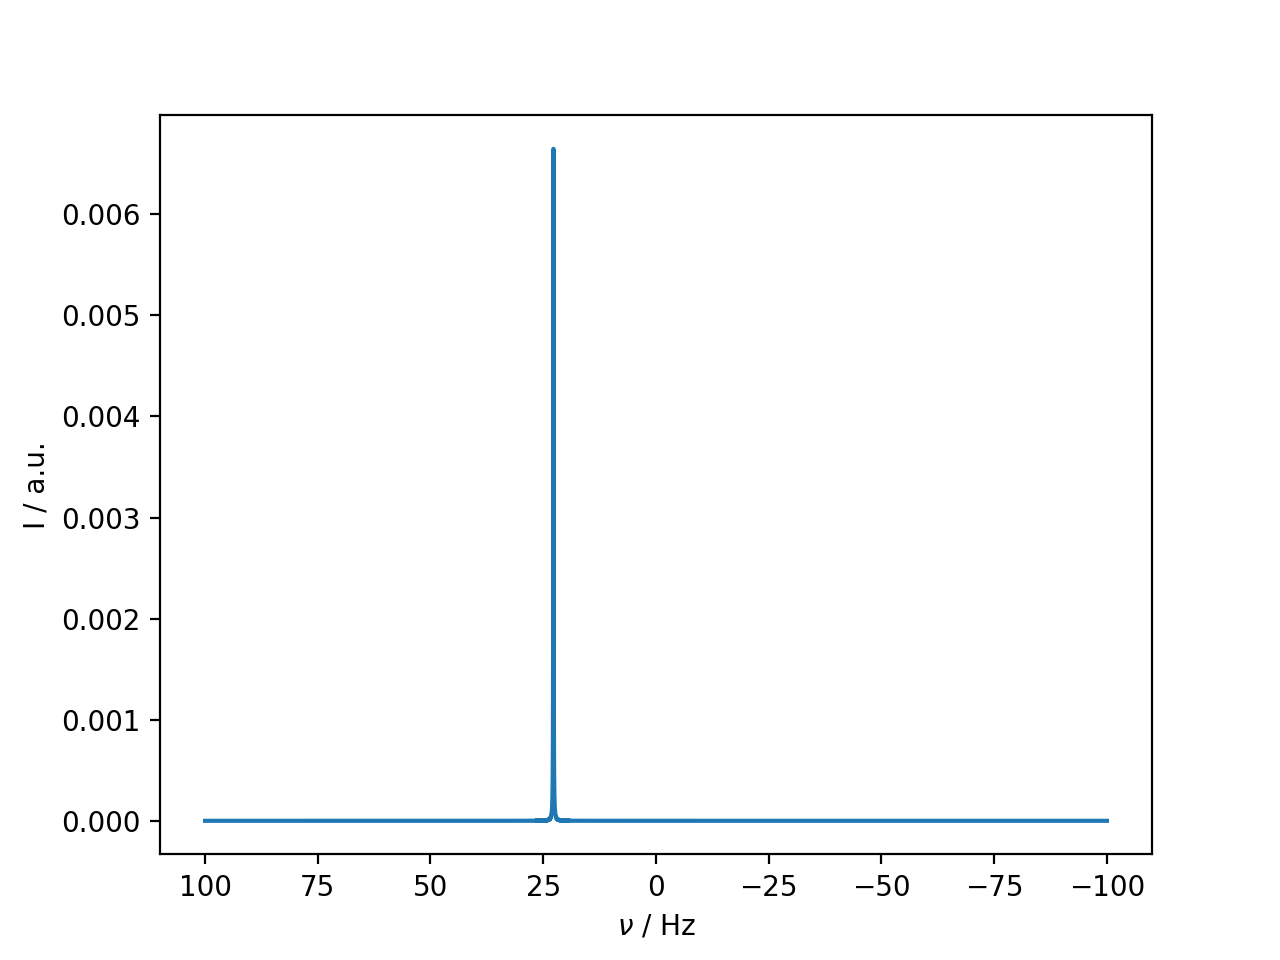

<AxesSubplot:xlabel='$\\nu$ / Hz', ylabel='I / a.u.'>

In [9]:
gxx,gyy,gzz=1,1,4
for k,ex0 in enumerate(ex):
    if k==0:
        ex0.set_inter('g',i=1,gxx=gxx,gyy=gyy,gzz=gzz,euler=[g_euler,[0,0,0]])
    else:
        ex0.set_inter('g',i=1,gxx=gxx,gyy=gyy,gzz=gzz,euler=[g_euler,[0,phi_tetra,(k-1)*2*np.pi/3]])
    
L=RS.Liouvillian(ex)
L.kex=RS.Tools.fourSite_sym(tc=1e-9)  #Four site symmetric exchange

L.add_relax(Type='T1',i=1,T1=1e-12)
L.add_relax(Type='T2',i=1,T2=1e-12)
L.add_relax(Type='recovery')

U=L.U(Dt=5e-3)

rho=RS.Rho(rho0='13Cx',detect='13Cp')
rho.DetProp(U,n=4000)
rho.downmix()
rho.plot(FT=True,apodize=True)

### Verify temperature dependence
We will re-run the above simulation, but as a function of temperature to confirm its dependence on the temperature

<IPython.core.display.Javascript object>


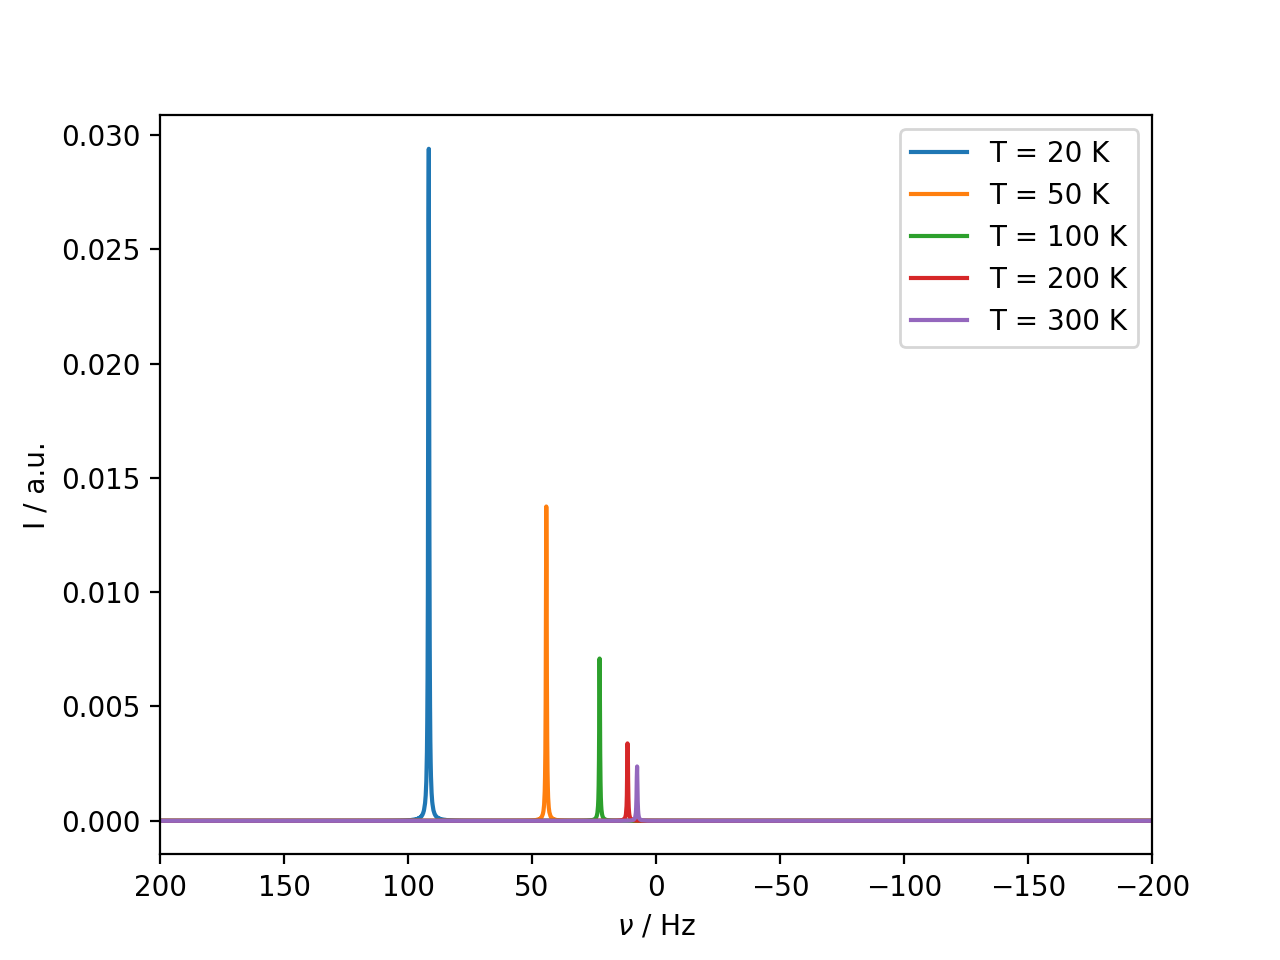

In [11]:
ax=plt.subplots(1,1)[1]
T0=[20,50,100,200,300]
for T in T0:
    L.expsys.T_K=T
    L.clear_relax()
    L.add_relax(Type='T1',i=1,T1=1e-12)  #Add T1 relaxation (1 ns). 
    L.add_relax(Type='T2',i=1,T2=1e-12) #Add T2 relaxation (ensure physical system)
    L.add_relax(Type='recovery')
    
    U=L.U(Dt=1e-3)

    rho=RS.Rho(rho0='13Cx',detect='13Cp')
    rho.DetProp(U,n=4000)
    rho()
    rho.downmix()
    rho.plot(ax=ax,FT=True,apodize=True)
ax.set_xlim([200,-200])
ax.legend([f'T = {T} K' for T in T0])

### Is the g-tensor anisotropy required?
We'll re-run the above calculation with an isotropic g-tensor to see what impact this has

<IPython.core.display.Javascript object>


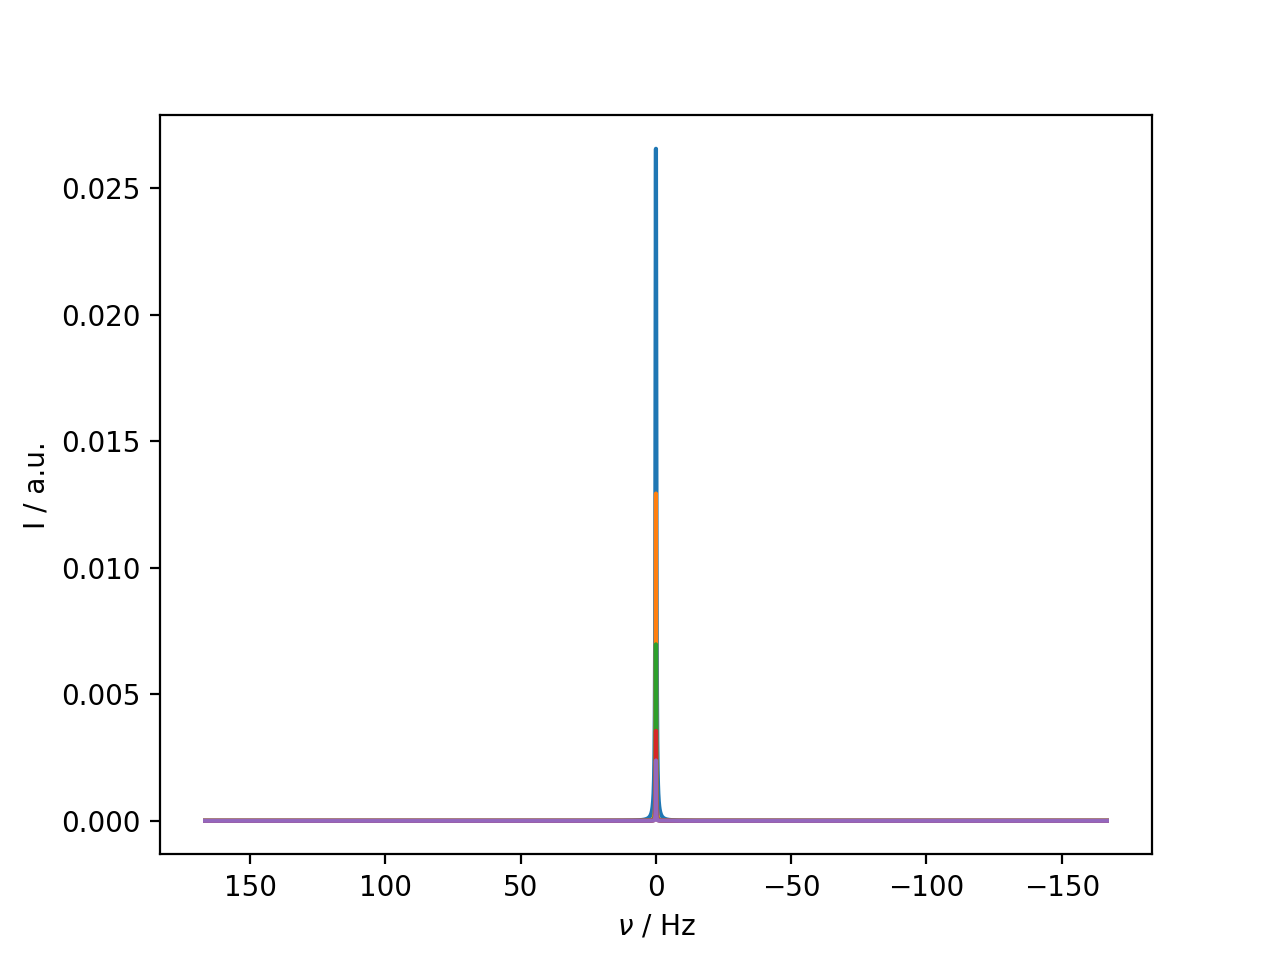

In [12]:
for ex0 in ex:
    ex0.set_inter('g',i=1,gxx=2,gyy=2,gzz=2)  #Set isotropic g-tensor

#We have to re-build the Liouvillian after editing interactions
L=RS.Liouvillian([ex[k] for k in [0,1,2,3]])
L.kex=RS.Tools.fourSite_sym(tc=1e-9)  #Four site symmetric exchange


ax=plt.subplots(1,1)[1]
T0=[10,50,100,200,300]
for T in T0:
    L.expsys.T_K=T
    L.clear_relax()
    L.add_relax(Type='T1',i=1,T1=1e-12)  #Add T1 relaxation (1 ns). 
    L.add_relax(Type='T2',i=1,T2=1e-12) #Add T2 relaxation (ensure physical system)
    L.add_relax(Type='recovery')
    
    U=L.U(Dt=3e-3)

    rho=RS.Rho(rho0='13Cx',detect='13Cp')
    rho.DetProp(U,n=4000)
    rho()
    rho.downmix()
    rho.plot(ax=ax,FT=True,apodize=True)

The effect has vanished, confirming that we do require anistropy of the g-tensor to tilt the electron quantization axis away from the magnetic field's $z$-axis

## Pseudocontact Shift under MAS

In [ ]:
delta=2e4
gxx,gyy,gzz=1,1,4
g_euler=[0,2*np.pi/5,0]

ex=RS.ExpSys(v0H=600,vr=10000,Nucs=['13C','e-'],T_K=50,LF=True,pwdavg=RS.PowderAvg(q=8))
ex.set_inter('hyperfine',i0=0,i1=1,Axx=-delta/2,Ayy=-delta/2,Azz=delta)
ex.set_inter('g',i=1,gxx=gxx,gyy=gyy,gzz=gzz,euler=g_euler)

L=RS.Liouvillian(ex)

L.add_relax(Type='T1',i=1,T1=1e-9)
L.add_relax(Type='T2',i=1,T2=1e-12)
L.add_relax(Type='recovery')

U=L.U()**10

rho=RS.Rho(rho0='13Cx',detect='13Cp')
rho.DetProp(U,n=100)
rho.downmix()


<IPython.core.display.Javascript object>


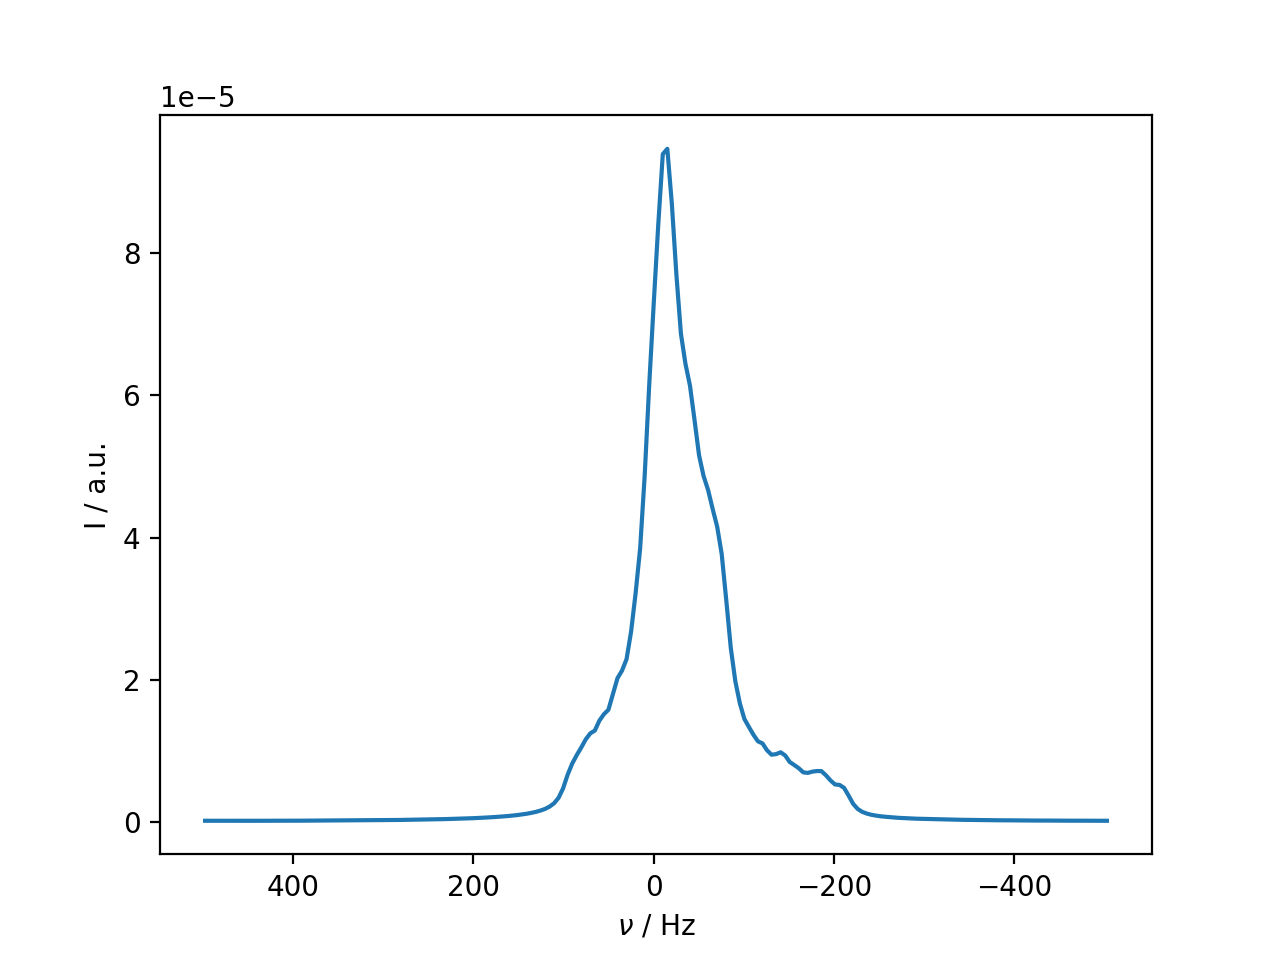

<AxesSubplot:xlabel='$\\nu$ / Hz', ylabel='I / a.u.'>

In [39]:
rho.plot(FT=True,apodize=True)

Below, we test the impact of removing the g-tensor anisotropy, to determine if MAS can spin out the pseudocontact shift when the electron quantization axis is along $z$.

We can also verify that the effect is temperature dependent, by observing the narrowing of the lineshape upon temperature increase

<IPython.core.display.Javascript object>


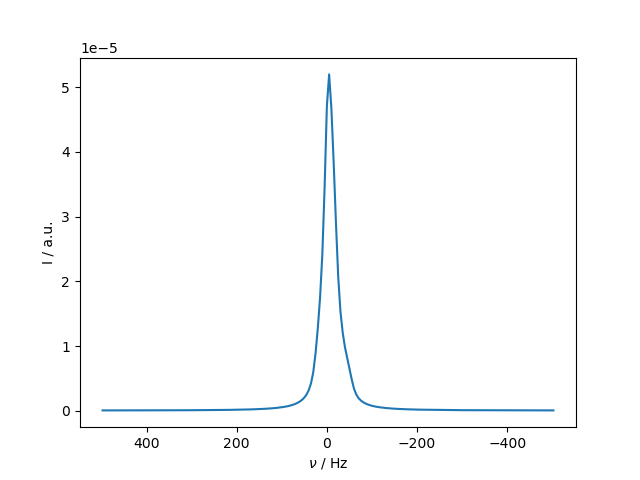

<AxesSubplot:xlabel='$\\nu$ / Hz', ylabel='I / a.u.'>

In [27]:
ex=RS.ExpSys(v0H=600,vr=10000,Nucs=['13C','e-'],T_K=200,LF=True,pwdavg=RS.PowderAvg(q=8))
ex.set_inter('hyperfine',i0=0,i1=1,Axx=-delta/2,Ayy=-delta/2,Azz=delta)
ex.set_inter('g',i=1,gxx=1,gyy=1,gzz=4,euler=g_euler)

L=RS.Liouvillian(ex)

L.add_relax(Type='T1',i=1,T1=1e-9)
L.add_relax(Type='T2',i=1,T2=1e-12)
L.add_relax(Type='recovery')

U=L.U()**10

rho=RS.Rho(rho0='13Cx',detect='13Cp')
rho.DetProp(U,n=100)
rho.downmix()
rho.plot(FT=True,apodize=True)

Finally, we note that the pseudocontact shift itself, if modulated by exchange, can result in relaxation. Here, we investigate its influence on the $R_{1\rho}$.

Note we have to perform this experiment in a mixed rotating (nucleus) / lab (electron) frame, to allow application of the RF field to the nucleus while retaining the electron tilting in the lab frame of the electron.

In [65]:
RS.Defaults['parallel']=False
delta=2e4
gxx,gyy,gzz=1,1,4
g_euler=[0,2*np.pi/5,0]

ex0=RS.ExpSys(v0H=600,vr=40000,Nucs=['13C','e-'],T_K=200,LF=[False,True],pwdavg=RS.PowderAvg(q=3))
ex0.set_inter('hyperfine',i0=0,i1=1,Axx=-delta/2,Ayy=-delta/2,Azz=delta)
ex0.set_inter('g',i=1,gxx=gxx,gyy=gyy,gzz=gzz,euler=g_euler)

ex1=ex0.copy()
ex1.set_inter('hyperfine',i0=0,i1=1,Axx=-delta/2,Ayy=-delta/2,Azz=delta,euler=[0,np.pi/4,0])

L=RS.Liouvillian((ex0,ex1))

L.kex=RS.Tools.twoSite_kex(tc=5e-6)
L.add_relax(Type='T1',i=1,T1=1e-9)
L.add_relax(Type='T2',i=1,T2=1e-12)


seq=L.Sequence()
seq.add_channel('13C',v1=35000)

#First calculate without exchange
U=seq.U()**100

rho=RS.Rho(rho0='13Cx',detect='13Cx')
rho.DetProp(U,n=300)

#Now add thermal polarization
L.add_relax(Type='recovery')
U=seq.U()**100

rho1=RS.Rho(rho0='13Cx',detect=f'{L.expsys.Peq[0]/2}*13Cx')
_=rho1.DetProp(U,n=300)


#Finally, lower the temperature
L.expsys.T_K=50
L.clear_relax()
L.add_relax(Type='T1',i=1,T1=1e-9)
L.add_relax(Type='T2',i=1,T2=1e-12)
L.add_relax(Type='recovery')
U=seq.U()**100

rho2=RS.Rho(rho0='13Cx',detect=f'{L.expsys.Peq[0]/2}*13Cx')
_=rho2.DetProp(U,n=300)

<IPython.core.display.Javascript object>


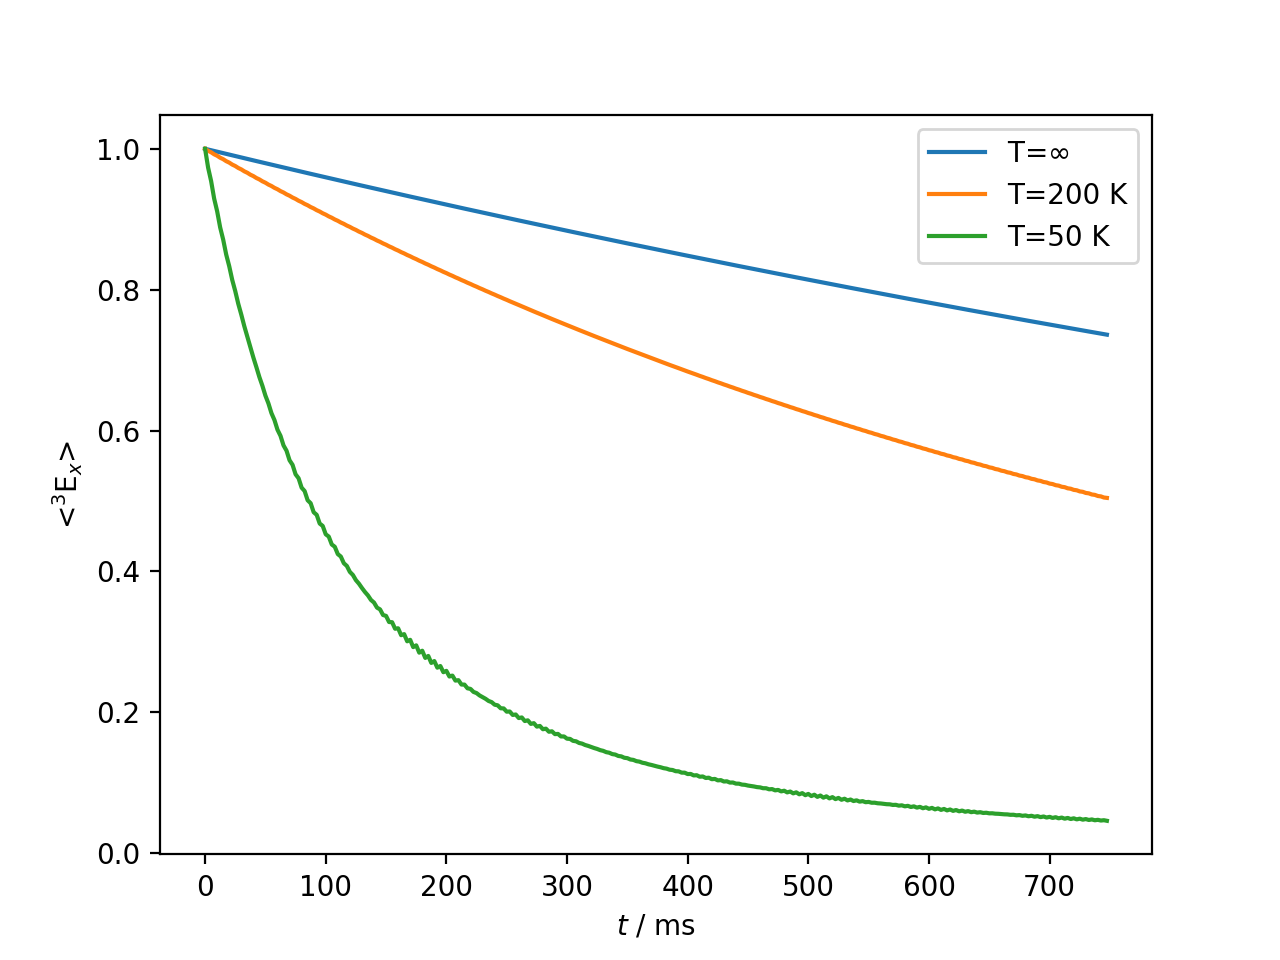

In [66]:
ax=rho.plot()
rho1.plot(ax=ax)
rho2.plot(ax=ax)
_=ax.legend([r'T=$\infty$','T=200 K','T=50 K'])

Some relaxation occurs without the exchange on the pseudocontact shift, possibly originating with the electron relaxation or some residual hyperfine coupling in exchange. However, when we add polarization to the electron, we see a distinct increase in the $R_{1\rho}$ relaxation rate constant, which is due to exchange modulation of the pseudocontact shift.

Note that this effect does *NOT* depend heavily on the presence of an anistropic g-tensor, as we demonstrate below by removing the anisotropy, and nonetheless obtain similar results.

In [67]:
RS.Defaults['parallel']=False
delta=2e4
gxx,gyy,gzz=2,2,2
g_euler=[0,2*np.pi/5,0]

ex0=RS.ExpSys(v0H=600,vr=40000,Nucs=['13C','e-'],T_K=200,LF=[False,True],pwdavg=RS.PowderAvg(q=3))
ex0.set_inter('hyperfine',i0=0,i1=1,Axx=-delta/2,Ayy=-delta/2,Azz=delta)
ex0.set_inter('g',i=1,gxx=gxx,gyy=gyy,gzz=gzz,euler=g_euler)

ex1=ex0.copy()
ex1.set_inter('hyperfine',i0=0,i1=1,Axx=-delta/2,Ayy=-delta/2,Azz=delta,euler=[0,np.pi/4,0])

L=RS.Liouvillian((ex0,ex1))

L.kex=RS.Tools.twoSite_kex(tc=5e-6)
L.add_relax(Type='T1',i=1,T1=1e-9)
L.add_relax(Type='T2',i=1,T2=1e-12)


seq=L.Sequence()
seq.add_channel('13C',v1=35000)

#First calculate without exchange
U=seq.U()**100

rho=RS.Rho(rho0='13Cx',detect='13Cx')
rho.DetProp(U,n=300)

#Now add thermal polarization
L.add_relax(Type='recovery')
U=seq.U()**100

rho1=RS.Rho(rho0='13Cx',detect=f'{L.expsys.Peq[0]/2}*13Cx')
_=rho1.DetProp(U,n=300)


#Finally, lower the temperature
L.expsys.T_K=50
L.clear_relax()
L.add_relax(Type='T1',i=1,T1=1e-9)
L.add_relax(Type='T2',i=1,T2=1e-12)
L.add_relax(Type='recovery')
U=seq.U()**100

rho2=RS.Rho(rho0='13Cx',detect=f'{L.expsys.Peq[0]/2}*13Cx')
_=rho2.DetProp(U,n=300)

<IPython.core.display.Javascript object>


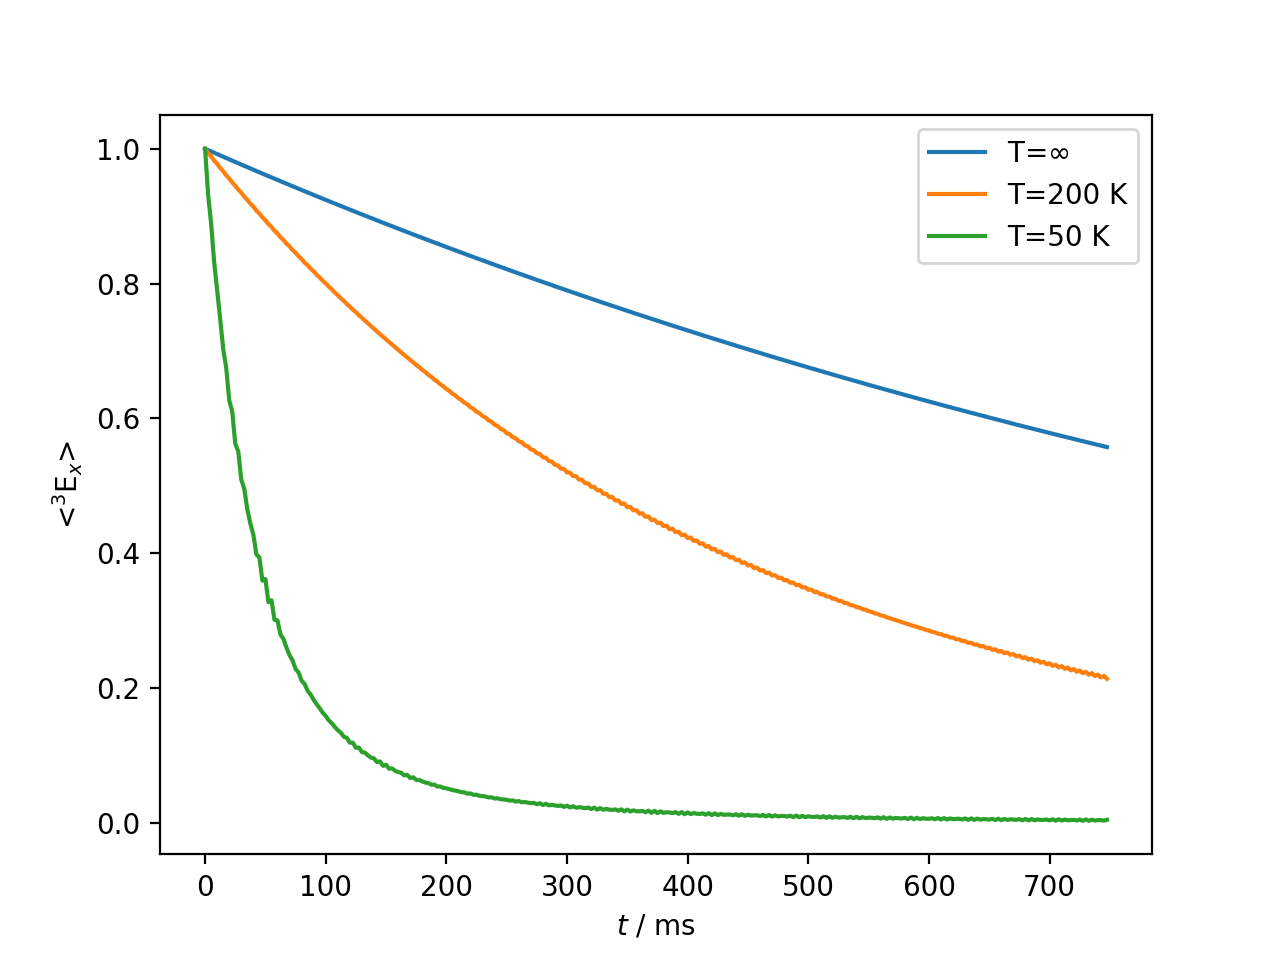

In [68]:
ax=rho.plot()
rho1.plot(ax=ax)
rho2.plot(ax=ax)
_=ax.legend([r'T=$\infty$','T=200 K','T=50 K'])